# Preprocessing steps of csv data

Using all techniques for normalization and vectorization avaliable to let data get transformed to numeric form for further use in algorithms and ML models.

In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# natural language toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer

import re
import string
import random

from sklearn.preprocessing import LabelEncoder

from gensim.parsing.preprocessing import remove_stopwords

In [37]:
stop_words = set(stopwords.words('english'))

## Reading the training data

In [38]:
data_train = pd.read_csv('Data/Corona_train.csv', encoding="latin1")
data_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
4,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive


In [39]:
print(f'Number of obs: {data_train.shape[0]}')
print(f'Number of cols: {data_train.shape[1]}')
print(f'Name of columns: {data_train.columns.values}')

Number of obs: 41156
Number of cols: 6
Name of columns: ['UserName' 'ScreenName' 'Location' 'TweetAt' 'OriginalTweet' 'Sentiment']


Text(0.5, 1.0, 'Distribution of Tweets by Sentiment Class in training dataset')

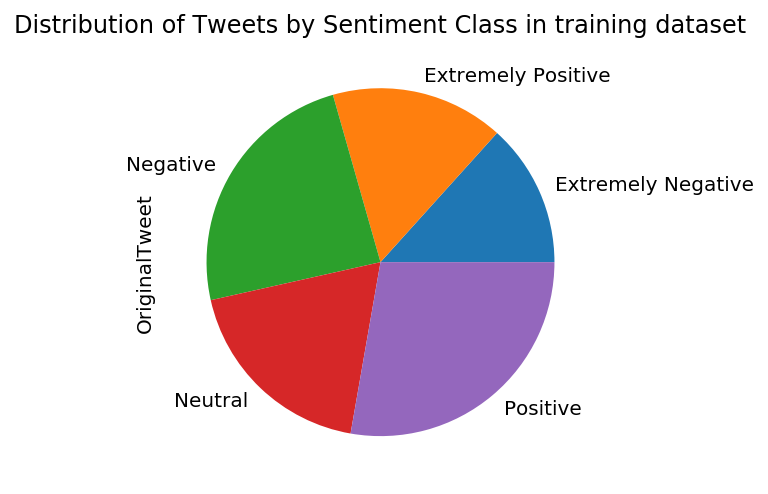

In [40]:
# groping them by sentiment
sentiment_class = data_train['OriginalTweet'].groupby(data_train.Sentiment).count()
ax = sentiment_class.plot(kind='pie')
ax.set_title('Distribution of Tweets by Sentiment Class in training dataset')

In [41]:
# in percentages:
sentiment_class_per = sentiment_class/data_train.shape[0]*100
print(sentiment_class_per) 

Sentiment
Extremely Negative    13.317621
Extremely Positive    16.094859
Negative              24.096122
Neutral               18.738459
Positive              27.752940
Name: OriginalTweet, dtype: float64


Text(0.5, 1.0, 'Distribution of classes in training set in percentages')

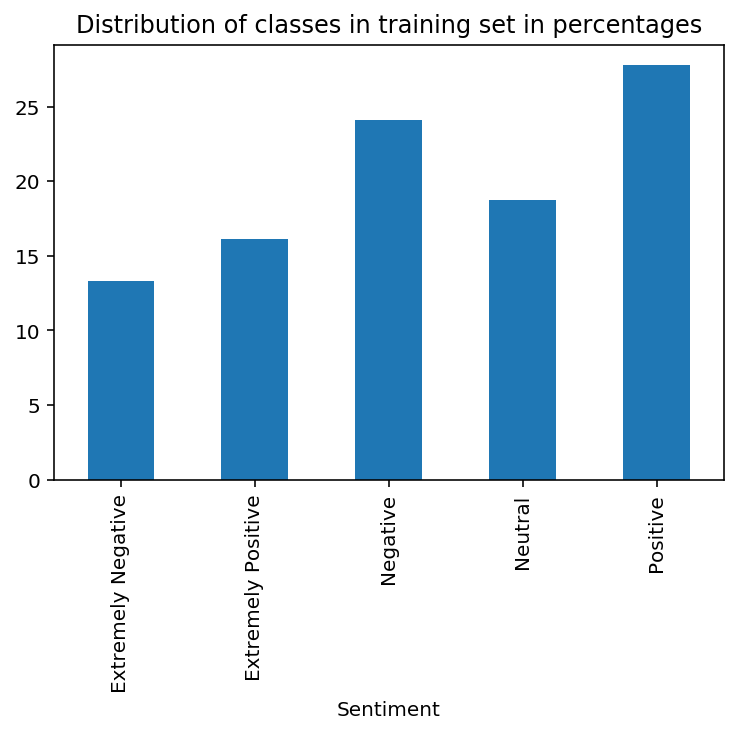

In [42]:
ax = sentiment_class_per.plot(kind='bar')
ax.set_title('Distribution of classes in training set in percentages')

In [43]:
# example of one tweet along with its sentiment:
data_train.iloc[5,4:6].values

array(['Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented "I\'m in Civics class so I know what I\'m talking about". https://t.co/ieFDNeHgDO',
       'Positive'], dtype=object)

## Reading the testing data

In [44]:
data_test = pd.read_csv('Data/Corona_test.csv', encoding="latin1")
data_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [45]:
print(f'Number of obs: {data_test.shape[0]}')
print(f'Number of cols: {data_test.shape[1]}')
print(f'Name of columns: {data_test.columns.values}')

Number of obs: 3798
Number of cols: 6
Name of columns: ['UserName' 'ScreenName' 'Location' 'TweetAt' 'OriginalTweet' 'Sentiment']


In [46]:
print(f'Test to Training ratio: {data_test.shape[0]/data_train.shape[0]}')
# there is only 10% testing compared to all the training data, we will see if this is good.

Test to Training ratio: 0.09228302070172029


Text(0.5, 1.0, 'Distribution of Tweets by Sentiment Class in testing dataset')

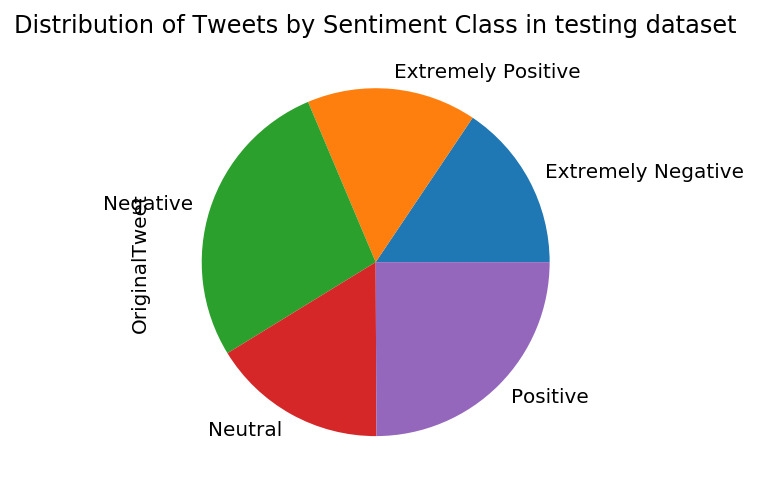

In [47]:
sentiment_test_class = data_test['OriginalTweet'].groupby(data_test.Sentiment).count()
ax = sentiment_test_class.plot(kind='pie')
ax.set_title('Distribution of Tweets by Sentiment Class in testing dataset')

In [48]:
# in percentages:
sentiment_test_class_per = sentiment_test_class/data_test.shape[0]*100
print(sentiment_test_class_per) 

Sentiment
Extremely Negative    15.587151
Extremely Positive    15.771459
Negative              27.409163
Neutral               16.298052
Positive              24.934176
Name: OriginalTweet, dtype: float64


In [49]:
data = {'Training data [%]': sentiment_class_per,
        'Testing data [%]': sentiment_test_class_per}
Sent_distribution = pd.concat(data, axis=1)
Sent_distribution

,Training data [%],Testing data [%]
Sentiment,,
Extremely Negative,13.317621,15.587151
Extremely Positive,16.094859,15.771459
Negative,24.096122,27.409163
Neutral,18.738459,16.298052
Positive,27.752940,24.934176


## Obtaining only the tweet and sentiment

We will deal only with the columns for the tweet and the sentiment. 

`train` will become the dataframe that contains the text and sentiment of the training data

`test` will become the dataframe containing the text and sentiment for testing data

In [50]:
train = data_train.iloc[:,4:6]
train.head(2)

,OriginalTweet,Sentiment
0,advice Talk to your neighbours family to excha...,Positive
1,Coronavirus Australia: Woolworths to give elde...,Positive


In [51]:
test = data_test.iloc[:,4:6]
test.head(2)

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive


In [52]:
# checking for NA values: 
train.isna().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [53]:
# NA values in testing data:
test.isna().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

## Encoding the sentiment classes

We will use encoding for the sentiment classes, so that the analysis gets easier when applying the models.

In [54]:
le = LabelEncoder()
train['Sentiment'] = le.fit_transform(train['Sentiment'])
train.head(2)

,OriginalTweet,Sentiment
0,advice Talk to your neighbours family to excha...,4
1,Coronavirus Australia: Woolworths to give elde...,4


In [55]:
test['Sentiment'] = le.fit_transform(test['Sentiment'])
test.head(2)

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,0
1,When I couldn't find hand sanitizer at Fred Me...,4


In [56]:
print(le.inverse_transform([0,1,2,3,4]))

['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive']


### We have applied the following encoding transformation:

`Extremely Negative`: 0

`Extremely Positive`: 1

`Negative`: 2

`Neutral`: 3

`Positive`: 4

## Cleaning the data from hashtags and twitter symbols

Removing all these symbols will facilitate our analysis and make the models understand the words better.

In [57]:
# transform train and test variables to numpy arrays:
train = train.to_numpy()
test = test.to_numpy()

In [58]:
# now we have both variables as numpy arrays
type(test), type(train)

(numpy.ndarray, numpy.ndarray)

In [59]:
train[:,0]

array(['advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P',
       "My food stock is not the only one which is empty...\r\n\r\n\r\n\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\n\r\nStay calm, stay safe.\r\n\r\n\r\n\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",
       ...,
       'You know itÂ\x92s getting tough when @KameronWilds  is rationing toilet paper #coronavirus #toiletpaper @kroger martinsville, help us out!!',
       'Is it wrong that the smell of hand sanitizer is starting to turn me on?\r\n\r\n\r\n\r\n#coronaviru

In [60]:
# for the training texts
for i in range(0,len(train)):
    text = train[i,0]
    text = re.sub("@\S+", " ", text)      # getting rid of mentions @
    text = re.sub("https*\S+", " ", text) # getting rid of links, that can be present everywhere
    text = re.sub("#\S+", " ", text)      # getting rid of hashtags
    text = re.sub("\'\w+", '', text)      # getting rid of spaces
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # changing punctuation
    text = re.sub(r'\w*\d+\w*', '', text) # remove prefixes
    text = re.sub('\s{2,}', " ", text)    # replaces two or more spaces by only one
    text = text.lower()                   # set all text to lower letters
    text = re.sub('gt gt gt', "", text)   # removes this series of words that are for no use
    train[i,0]=text         # store the new variable 


In [61]:
# for the testing cases:
for i in range(0,len(test)):
    text = test[i,0]
    text = re.sub("@\S+", " ", text)      # getting rid of @
    text = re.sub("https*\S+", " ", text) # getting rid of https, that can be present everywhere
    text = re.sub("#\S+", " ", text)      # getting rid of hashtags
    text = re.sub("\'\w+", '', text)      # getting rid of spaces
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # changing punctuation
    text = re.sub(r'\w*\d+\w*', '', text) # remove prefixes
    text = re.sub('\s{2,}', " ", text)    # replaces two or more spaces by only one
    text = text.lower()                   # set all text to lower letters
    test[i,0]=text         # store the new variable 


Now we will see if the texts look the way we would expect:

In [62]:
# training
for i in range(3):
    tweet = train[random.randint(0,len(train)-1),0]
    print('-------')
    print(tweet)

-------
because of youâve decreased store hours by hours please explain to me how this helps a better idea would be to close the retail part of your pharmacy and keep the drive through open 
-------
 fisher price amp baby sleeper is being recalled across australia after being linked to infant deaths in the united states the popular fisher price baby sleeper is being recalled across australia after being linked to 
-------
like never before excited about 


In [63]:
# training
for i in range(3):
    tweet = test[random.randint(0,len(test)-1),0]
    print('-------')
    print(tweet)

-------
what efforts are being carried out for disadvantaged communities for the quarantine i am sure many families can t stock pile food and medications for or weeks who is doing what put the info below so we can help each other thanks
-------
someone pulled a gun inside a toronto supermarket today 
-------
supermarket in barcelona sakuraâs innocent reaction via 


### We have now all the text free of symbols and in lower letters

## Removing stopwords

In [64]:
# get all stopwords
stop_words = set(stopwords.words('english')) 

# for the training set:
for i in range(0,len(train)-1):

    text = str(train[i,0])  # select the text in the obs. i
    text_clean = remove_stopwords(text)
    #word_tokens = word_tokenize(text_clean) 
    train[i,0] = text_clean

In [65]:
# for the testing set:
for i in range(0,len(test)-1):

    text = str(test[i,0])  # select the text in the obs. i
    text_clean = remove_stopwords(text)
    #word_tokens = word_tokenize(text_clean) 
    test[i,0] = text_clean

In [66]:
train[1,:], test[1,:]

(array(['coronavirus australia woolworths elderly disabled dedicated shopping hours amid covid outbreak',
        4], dtype=object),
 array(['couldn hand sanitizer fred meyer turned pack purell check concerns driving prices',
        4], dtype=object))

## Applying Lemmatization to further simplifying the sentences in the tweets

In [71]:
# converting to pandas dataframe
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

train_df.columns = ['tweet', 'label']
test_df.columns = ['tweet', 'label']

In [72]:
test_df.head()

,tweet,label
0,trending new yorkers encounter supermarket she...,0
1,couldn hand sanitizer fred meyer turned pack p...,4
2,protect loved ones,1
3,buying hits city anxious shoppers stock food a...,2
4,week buying baby milk powder buying toilet paper,3


In [78]:
# for the training set

train_df['Corpus'] = [nltk.word_tokenize(text) for text in train_df.tweet]
lemma = nltk.WordNetLemmatizer()
train_df.Corpus = train_df.apply(lambda x: [lemma.lemmatize(word) for word in x.Corpus], axis=1)
train_df.Corpus = train_df.apply(lambda x: " ".join(x.Corpus),axis=1)

# for the testing set

test_df['Corpus'] = [nltk.word_tokenize(text) for text in test_df.tweet]
lemma = nltk.WordNetLemmatizer()
test_df.Corpus = test_df.apply(lambda x: [lemma.lemmatize(word) for word in x.Corpus], axis=1)
test_df.Corpus = test_df.apply(lambda x: " ".join(x.Corpus),axis=1)

In [85]:
# selecting only label and corpus as they are the ones we will keep
covid_train = train_df[['Corpus', 'label']]
covid_test  = test_df[['Corpus', 'label']]

In [87]:
# no missing data
covid_train.isnull().sum(), covid_test.isnull().sum()

(Corpus    0
 label     0
 dtype: int64, Corpus    0
 label     0
 dtype: int64)

## Exporting preprocessed corpus of text as csv file for later analysis

In [88]:
# creating csv for training and testing cleaned files
covid_train.to_csv('Data/TweetC_train.csv', index=None)
covid_test.to_csv('Data/TweetC_test.csv', index=None)